In [1]:
from dataset import (
    BuildingDataset,
    show_segmentation,
    data_loaders,
    show_segmentation_v2,
    MiyazakiDataset,
    get_simple_transform,
)
from model import (
    ModelConfig,
    new_model,
    TwoMLPRegression,
    EnhancedTwoMLPRegression,
    SimpleBuildingHeightPred,
    new_pretrained_model,
)
from dataset import NUMBER_OF_CLASSES
import dataset
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms as T
import torch
import logging
from model import train, load_fine_tuned_model, show_prediction_results
from torch.nn import SmoothL1Loss

logging.getLogger("matplotlib").setLevel(logging.WARNING)

In [ ]:
def train_pretrained_model(model_name: str):
    model = new_pretrained_model(
        new_model_name=model_name,
        pretrained_checkpoint_path="checkpoints/pretrained_seg_miyazaki_epoch_9.pt",
        height_pred_class=EnhancedTwoMLPRegression,
        height_pred_loss_fn=SmoothL1Loss(),
        height_pred_after_roi_pool=True,
        sample_equal=False,
        map_location="cpu",
    )

    data_loader, data_loader_test = data_loaders(
        "datasets/images_annotated",
        dataset_cls=BuildingDataset,
        train_batch_size=2,
        test_batch_size=1,
        test_split=0.2,
        num_workers=4,
    )

    train(
        model,
        data_loader,
        data_loader_test,
        num_epochs=2,
        eval_iterations=0,
        checkpoint_dir="checkpoints",
        checkpoint_prune_threshold=3,
    )

    return model


model = train_pretrained_model("pretrained_model_v2")

INFO:root:Size of training set 1756. Sise of test set: 439
/Users/volodymyr/work/personal/building_height_detection/.venv/lib/python3.10/site-packages/torchvision/utils.py:224: UserWarning: Argument 'font_size' will be ignored since 'font' is not set.
  warnings.warn("Argument 'font_size' will be ignored since 'font' is not set.")


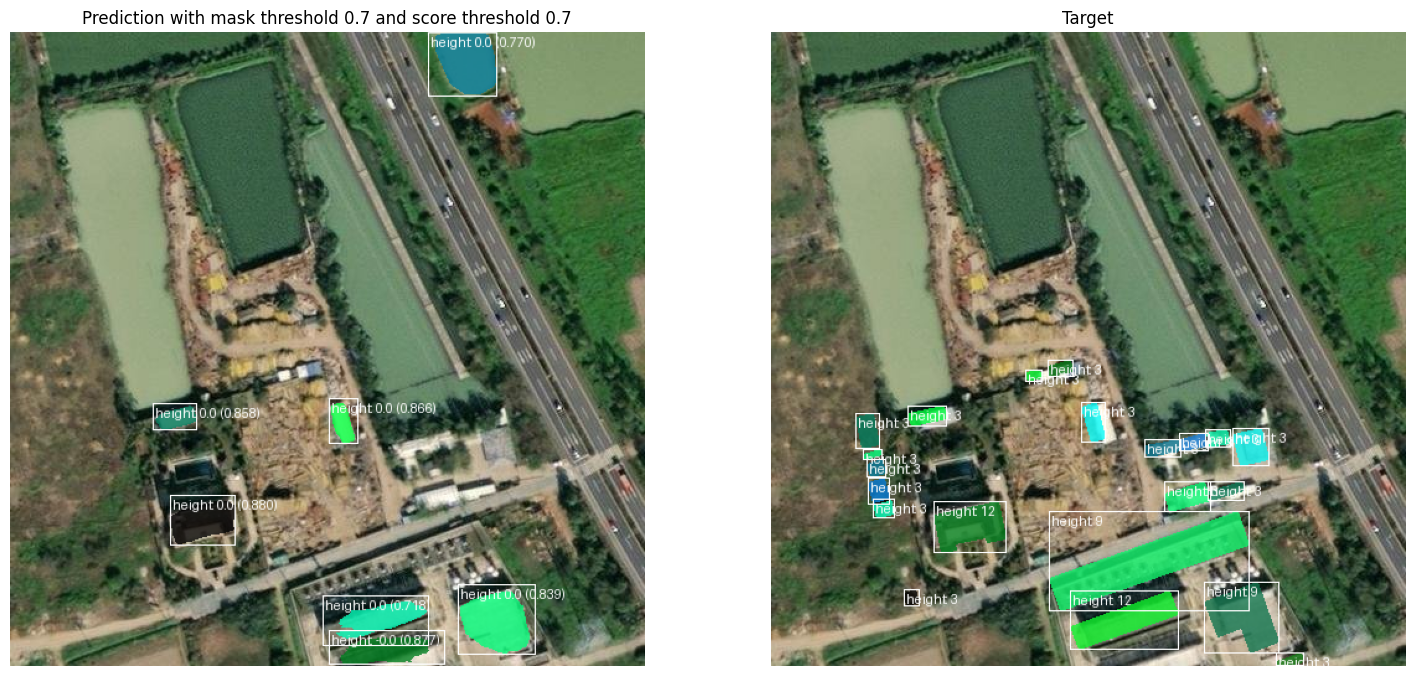

INFO:root:Prediction keys: dict_keys(['boxes', 'labels', 'scores', 'heights', 'masks'])


In [3]:
if "data_loader_test_inf" not in locals():
    model = load_fine_tuned_model("checkpoints/pretrained_model_v1_epoch_0.pt")

    data_loader_inf, data_loader_test_inf = data_loaders(
        "datasets/images_annotated",
        dataset_cls=BuildingDataset,
        train_batch_size=2,
        test_batch_size=1,
        test_split=0.2,
        num_workers=4,
    )

inf_images, inf_targets = next(iter(data_loader_test_inf))

predictions = show_prediction_results(
    model, inf_images, inf_targets, mask_threshold=0.7, box_score_threshold=0.7
)

logging.info(f"Prediction keys: {predictions[0].keys()}")

In [11]:
predictions[0]["masks"][0].unique()

tensor([0.0000, 0.0023, 0.0033,  ..., 0.9532, 0.9535, 0.9537],
       grad_fn=<Unique2Backward0>)

In [ ]:
model_cfg = ModelConfig(
    name="inf_model",
    num_classes=NUMBER_OF_CLASSES,
    mask_hidden_layer_size=256,
    trainable_backbone_layers=3,
)

model = new_model(model_cfg)

checkpoint_path = "checkpoints/pretrained_seg_miyazaki_epoch_9.pt"
checkpoint_dict = torch.load(checkpoint_path, map_location="cpu")
model.load_state_dict(checkpoint_dict["model_state_dict"], strict=True)

In [ ]:
data_loader, data_loader_test = data_loaders(
    "datasets/miyazaki",
    dataset_cls=MiyazakiDataset,
    get_transform=get_simple_transform,
    train_batch_size=13,
    test_batch_size=3,
    test_split=0.01,
    num_workers=8,
)
data_loader_test_inf_iter = iter(data_loader_test)

In [ ]:
og_data_loader, og_data_loader_test = data_loaders(
    "datasets/images_annotated/",
    dataset_cls=BuildingDataset,
    get_transform=get_simple_transform,
    train_batch_size=13,
    test_batch_size=3,
    test_split=0.01,
    num_workers=8,
)
og_data_loader_test_inf_iter = iter(og_data_loader_test)

In [ ]:
dataset = BuildingDataset(
    "datasets/images_annotated/",
    transforms=get_simple_transform(train=True),
)
dataset[1993][1]["image_name"]

In [ ]:
# inf_images, inf_targets = next(data_loader_test_inf_iter)
# inf_images, inf_targets = next(og_data_loader_test_inf_iter)
# inf_images, inf_targets = dataset[1321]
# inf_images = [inf_images]
# inf_targets = [inf_targets]
# inf_images = inf_images.unsqueeze(0)


predictions = show_prediction_results(
    model, inf_images, inf_targets, mask_threshold=0.6, box_score_threshold=0.6
)

logging.info(f"Prediction keys: {predictions[0].keys()}")

In [ ]:
inf_targets[0]["image_name"]